In [23]:
import pandas as pd
import numpy as np
import os
import random
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler
import data_processing.plotting as plotting

## 2. Preprocessing
Welcome to the second part of our tutorial.
This notebook will teach you how to preprocess a sensor based Human Activity Recognition dataset.

Data preprocessing is an essential part of any Deep Learning project. In this part you will learn which steps can or should be executed on a dataset, in order to train a working classifer.
To be able to choose the correct preprocessing steps, first we need to get to know our data. However, this topic has already been dealt with in Chapter 1.

In the first part we will work on the same subset, that we already had been working with in Chapter 1.
So let's start by reading in the dataset.

**Step 1: Reading the dataset**

In [24]:
data_folder = 'data'
dataset = '../data/rwhar_3sbjs_data.csv'
data = pd.read_csv(dataset,
                   names=['subject_id', 'acc_x', 'acc_y', 'acc_z', 'activity_label'])

#### 2.1 Cleaning
There can be several reasons why we need to clean up a dataset. For example, it is common that datasets has missing values.
These values need to be interpolated. PAMAP2 is one of the datasets that is used very frequently in scientific publications, which contains missing values.

An example to clean data from missing values, especially NaN-values, can be found in the file **data_precessing.preprocess.data.py**.

Also it can be beneficial to clean a dataset from noisy data or from outliers.
But be careful with cleaning the data from noise or outlier, since it only is recommendable if the noise/outlier is not from any importance for the use case of your model.

##### 2.2 Sensor Orientation

Whenever we are working with a multimodal dataset, which means a dataset that consists of data from different sensors,
we need to make sure that the sensor orientation of the data matches each other.

The following picture shows the different orientation of the two datasets PAMAP2 and Skoda mini checkpoint.
It illustrates that whenever you are merging different datasets or even data from different sensors, you need be sure that
the sensor orientations align with each other.

In [25]:
Image(url="../images/pamap_skoda_orientation.png", width=533, height=261)


#### 1.2 Resampling

Resampling is necessary if we work with data from sensors that recorded with different sampling rates.
Resampling can either be done by up- or downsample the data.

An example for a function that either up- or downsamples time series data, can be found as well in our collection of preprocessing function: **data_precessing.preprocess.data.py**.

#### 1.3 Normalizing
Normalizing is in an important part in the preprocessing chain, but can also the reason for many mistakes.
Therefore it is important to choose the correct strategy to normalize your dataset.
Therefore, we will dig deeper into this topic at this point of our tutorial.

##### 1.3.1 How to normalize?

The best ways to normalize a dataset is either sensor- or axis-wise. However, there certain pitfalls a programmer can fall into.
Normalizing sensor-wise means that whenever we have a dataset that contains data from different types of sensors, like e.g accelerometer and
magnetometer data, these data should never have been normalized together.

One of the reasons we want to normalize is, that we would like to give the same importance to every input feature.

The numerical values of magnetometer measurements are much higher than accelerometer values. Since normalizing both sensor data together, will
keep this imbalance, we can break this up by normalizing data sensor- or even axis-wise.

However, data from one sensor or one axis should be kept together, and not be separated either user- or activity-wise before normalization. Otherwise,
the data will be distorted.

To illustrate the problem, let's look at the following code.

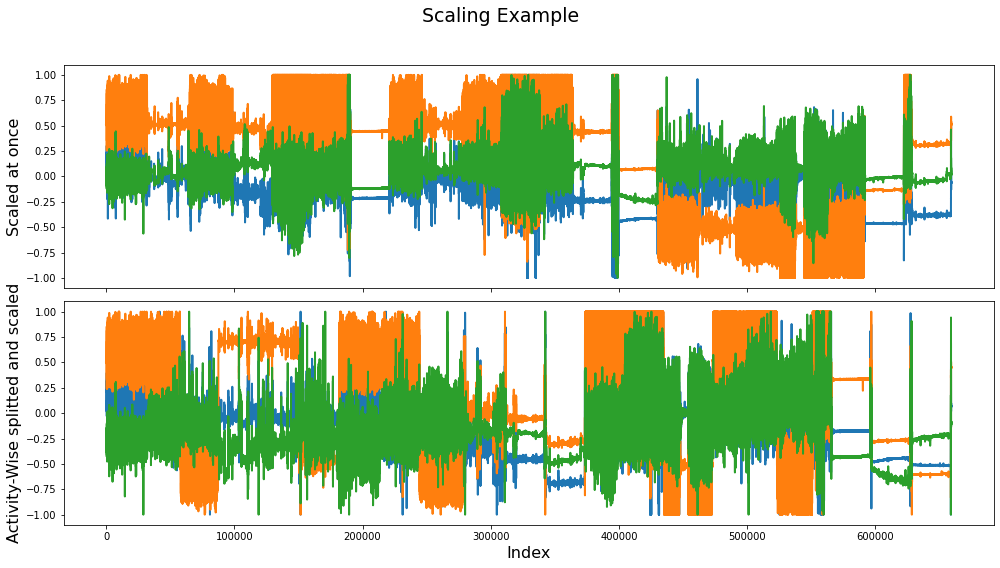

In [26]:
scaler = MinMaxScaler(feature_range=[-1,1])
data_activity_wise = {}
data_activity_wise_scaled = []
all_activites = data['activity_label'].unique()
for activity in all_activites:
    data_activity_wise[activity] = data.loc[data['activity_label'] == activity]

for activity, activity_data in data_activity_wise.items():
    data_activity_wise_scaled.append(scaler.fit_transform(activity_data[['acc_x', 'acc_y', 'acc_z']]))

data_scaled_at_once = scaler.fit_transform(data[['acc_x', 'acc_y', 'acc_z']])
data_activity_wise = pd.concat(data_activity_wise_scaled)

plotting.plot_imu_data(data_scaled_at_once, data_activity_wise, "Scaling Example")

before / after

Normalizing axis-wise

before / after


In [ ]:
scaler_axiswise = MinMaxScaler(feature_range=[-1,1])
scaled_x = scaler_axiswise.fit_transform(interpolated_data["acc_x"].values.reshape(-1,1))
scaled_y = scaler_axiswise.fit_transform(interpolated_data["acc_y"].values.reshape(-1,1))
scaled_z = scaler_axiswise.fit_transform(interpolated_data["acc_z"].values.reshape(-1,1))


Batch-Normalization
Where to put in the architecture?
According to citation[] batch normalization layers should be placed after convolutional layers.


#### 1.4 Windowing
##### 1.4.1 Jumping/Sliding Window

https://docs.microsoft.com/en-us/azure/stream-analytics/stream-analytics-window-functions

Shuffling
